In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook

# Load ACL training data.
train_acl = pd.read_csv('../content/drive/MyDrive/MRNet-v1.0/train-acl.csv', header=None,
                        names=['Case', 'Abnormal'], dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()


Case  Abnormal
0  0000         0
1  0001         1
2  0002         0
3  0003         0
4  0004         0

In [ ]:
print(train_acl.shape)
# (1130, 2)

(1130, 2)


In [ ]:
train_acl.Abnormal.value_counts(normalize=True)  # Calculates the proportion of each unique value in the 'Abnormal' column.


Abnormal
0    0.815929
1    0.184071
Name: proportion, dtype: float64

In [ ]:
case = '0000'

mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/1130.npy')


print(f'MRI scan on axial plane: {mri_axial.shape}')


MRI scan on axial plane: (25, 256, 256)


Text(0.5, 1.0, 'Case 0 | Slice 1 | Axial')

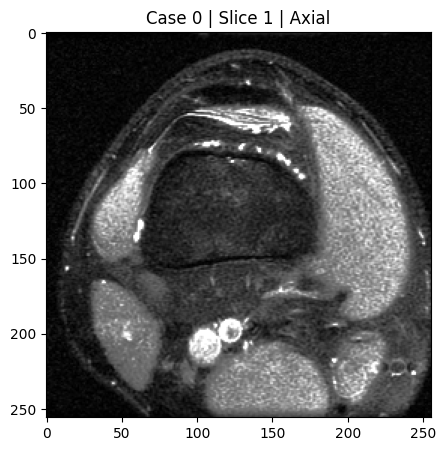

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))  # Single plot.

ax.imshow(mri_axial[0, :, :], 'gray')  # Display image in grayscale.
ax.set_title('Case 0 | Slice 1 | Axial')


In [ ]:
train_path = '../content/drive/MyDrive/MRNet-v1.0/train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('../content/drive/MyDrive/MRNet-v1.0/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()
    else:
        case_list = pd.read_csv('../content/drive/MyDrive/MRNet-v1.0/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()
    cases = {}

    if n is not None:
        case_list = case_list[:n]

    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)

In [ ]:
print(cases['0000'].keys())

dict_keys(['coronal', 'sagittal', 'axial'])


In [ ]:
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
K.set_image_data_format("channels_last")

In [ ]:
def trainingSet(file_name):
    training_set = []
    for np_name in sorted(glob.glob('../content/drive/MyDrive/MRNet-v1.0/train/'+file_name+'/*.npy')):
        training_set.append(np.load(np_name))
    return training_set

In [ ]:
def load_labels(train_file_name):
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    return training_labels

In [13]:
#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [ ]:
#load the training data for each angle of the knee
training_set_axial= trainingSet('axial')

In [ ]:
training_set_coronal=trainingSet('coronal')

In [ ]:
training_set_sagittal=trainingSet('sagittal')

In [ ]:
#extract the middel 3 slices from each stack
training_set_axial = extract_3(training_set_axial, 1130)


In [ ]:
#load the labels of the trainig data for each knee tear

training_label_acl = load_labels('../content/drive/MyDrive/MRNet-v1.0/train-acl.csv')


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.01,
        fill_mode='nearest')

In [ ]:
def data_augmentation(dataset, labels):
  augmented_data = []
  augmented_labels = []
  num_augmented = 0
  for X_batch, y_batch in datagen.flow(dataset, labels, batch_size= dataset.shape[0], shuffle=False):
      augmented_data.append(X_batch)
      augmented_labels.append(y_batch)
      num_augmented += dataset.shape[0]
      if num_augmented == dataset.shape[0] * 2:
          break

  dataset = np.array(augmented_data).reshape(num_augmented, 256, 256, 3)
  labels = np.array(augmented_labels).reshape(num_augmented, 1)
  return dataset, labels

In [ ]:
training_set_axial, training_label_acl = data_augmentation(training_set_axial, training_label_acl)

training_set_axial.shape

(4520, 256, 256, 3)

In [ ]:
#load INCEPTIONV3 pretrainned model from keras without the top layer &
#specify the shape of the input image as (256x256x3)
mri_InceptionV3 = InceptionV3(include_top = False, input_shape = (256, 256, 3))#  defaults to imagenet

#remove the last one
mri_InceptionV3.layers.pop()

#get the output of the INCEPTIONV# model "feature extraction" and add Dense layers so that the model is designed
#to classify our data
mri_InceptionV3_output = mri_InceptionV3.output

mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

mri_InceptionV3_last_layer = Dense(1024, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(128, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(32, activation = 'relu')(mri_InceptionV3_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

modified_mri_InceptionV3 = Model(inputs = mri_InceptionV3.input, outputs = predictor)

modified_mri_InceptionV3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 24,036,321 (91.69 MB)

 Trainable params: 24,001,889 (91.56 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
#freeze the added dense layers and unfreeze the rest:
for layer in modified_mri_InceptionV3.layers[15:]:
    layer.trainable = True

for layer in mri_InceptionV3.layers:
    layer.trainable = False

modified_mri_InceptionV3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
    val_targ = self.validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    print ('-val_f1 : %f '%(_val_f1))
    return
metrics = Metrics()

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow

class Metrics(tensorflow.keras.callbacks.Callback):
    def __init__(self,val_x, val_y, batch_size = 20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size
    def on_train_begin(self, logs=None):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x    = self.val_x
        targ = self.val_y

        score   = np.asarray(self.model.predict(x))
        predict = np.round(np.asarray(self.model.predict(x)))
        self.f1s.append(f1_score(targ, predict, average='micro'))
        self.confusion.append(confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1)))
        print("\nAt epoch {} f1_score {}:".format(epoch, self.f1s[-1]))
        print('\nAt epoch {} cm {}'.format(epoch, self.confusion[-1]))
        return

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns # Import seaborn

K.set_image_data_format("channels_last")

# ... (rest of your code) ...

def plot_history(history):
  plt.figure(figsize=(8, 6))
  ax = plt.gca()
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='Loss')
  plt.plot(history.epoch, history.history['val_loss'], label='validation error')
  plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
  plt.plot(history.epoch, history.history['val_accuracy'], label='validation accuracy')
  plt.plot(metrics.val_f1s, label='f_score')
  plt.grid(True,color='white')

  # Apply the seaborn style
  sns.set_style('darkgrid') # or plt.style.use('seaborn') if just the style is needed

  plt.legend()

# ... (rest of your code) ...

In [ ]:
#train the model with 1073 trainning data & 57 validation data
#save the model that has the max validation accuracy
#at the end plot the trainng loss & accuracy, validation loss & accuracy & F-score
def fit_model(training_set, training_labels, model_file_name):

    history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.05,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'max'),
                          ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')]) # Change 'period' to 'save_freq='epoch'' to save every epoch
    plot_history(history)
    best_model = load_model(model_file_name +'.keras')
    return best_model

Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 71s 527ms/step - accuracy: 0.8665 - loss: 0.2964 - val_accuracy: 0.8407 - val_loss: 0.3584
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 71s 526ms/step - accuracy: 0.9005 - loss: 0.2332 - val_accuracy: 0.8540 - val_loss: 0.3236
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 518ms/step - accuracy: 0.8751 - loss: 0.2923 - val_accuracy: 0.7876 - val_loss: 0.3875
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 517ms/step - accuracy: 0.8922 - loss: 0.2561 - val_accuracy: 0.8496 - val_loss: 0.3770
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 519ms/step - accuracy: 0.8818 - loss: 0.2719 - val_accuracy: 0.7876 - val_loss: 0.4305


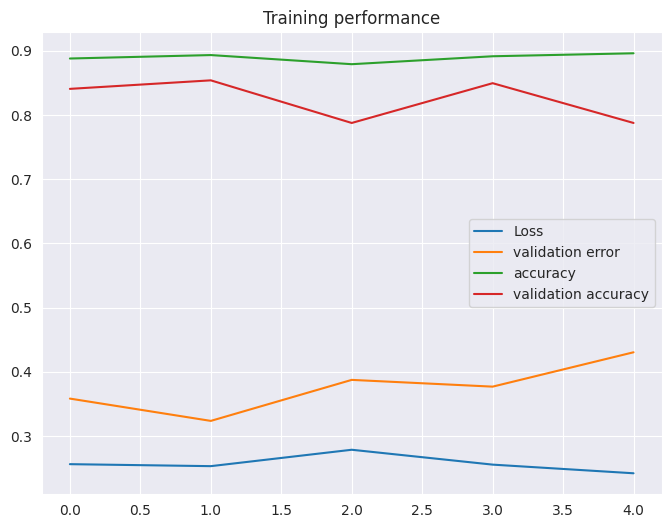

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_abnormal, "./axial_abnormal_model")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Set image data format
K.set_image_data_format("channels_last")

# Load InceptionResNetV2 pre-trained model from keras without the top layer &
# specify the shape of the input image as (256x256x3)
mri_InceptionResNetV2 = InceptionResNetV2(include_top=False, input_shape=(256, 256, 3))

# Get the output of the InceptionResNetV2 model ("feature extraction") and add Dense layers
# so that the model is designed to classify our data
mri_InceptionResNetV2_output = mri_InceptionResNetV2.output

mri_InceptionResNetV2_last_layer = GlobalMaxPooling2D()(mri_InceptionResNetV2_output)

mri_InceptionResNetV2_last_layer = Dense(1024, activation='relu')(mri_InceptionResNetV2_last_layer)

mri_InceptionResNetV2_last_layer = Dense(128, activation='relu')(mri_InceptionResNetV2_last_layer)

mri_InceptionResNetV2_last_layer = Dense(32, activation='relu')(mri_InceptionResNetV2_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionResNetV2_last_layer)

# Create the modified model
modified_mri_InceptionResNetV2 = Model(inputs=mri_InceptionResNetV2.input, outputs=predictor)

# Freeze the added dense layers and unfreeze the rest:
for layer in modified_mri_InceptionResNetV2.layers[15:]:
    layer.trainable = True

for layer in mri_InceptionResNetV2.layers:
    layer.trainable = False

# Compile the model with an updated optimizer and metrics
modified_mri_InceptionResNetV2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Updated learning rate for better performance
    metrics=['accuracy']
)

# Display the summary of the modified model
modified_mri_InceptionResNetV2.summary()

# Define a custom callback for tracking F1 score, precision, recall, and confusion matrix
class Metrics(Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x
        targ = self.val_y

        score = np.asarray(self.model.predict(x, batch_size=self.batch_size))
        predict = np.round(score)

        _f1 = f1_score(targ, predict, average='micro')
        cm = confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1))

        self.f1s.append(_f1)
        self.confusion.append(cm)

        print(f"\nAt epoch {epoch} F1-score: {_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        return

# Instantiate the custom metrics callback
metrics = Metrics(val_x=training_set_axial, val_y=training_label_acl)

# Add early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')  # Use .keras format
]

# Define the fit_model function for training and evaluation
def fit_model(training_set, training_labels, model_file_name):
    history = modified_mri_InceptionResNetV2.fit(
        x=training_set,
        y=training_labels,
        batch_size=32,
        epochs=30,
        validation_split=0.05,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_loss', mode='min'),
            ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')
        ]
    )
    plot_history(history)
    best_model = load_model(model_file_name + '.keras')


    return best_model

# Plot training performance
def plot_history(history):
    plt.figure(figsize=(8, 6))
    sns.set_style('darkgrid')
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    if hasattr(metrics, 'f1s'):
        plt.plot(metrics.f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, color='white')
    plt.show()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2530 (Conv2D)      │ (None, 127, 127, 32)   │            864 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2530  │ (None, 127, 127, 32)   │             96 │ conv2d_2530[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2530           │ (None, 127, 127, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2531 (Conv2D)      │ (None, 125, 125, 32)   │          9,216 │ activation_2530[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2531  │ (None, 125, 125, 32)   │             96 │ conv2d_2531[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2531           │ (None, 125, 125, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2532 (Conv2D)      │ (None, 125, 125, 64)   │         18,432 │ activation_2531[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2532  │ (None, 125, 125, 64)   │            192 │ conv2d_2532[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2532           │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 62, 62, 64)     │              0 │ activation_2532[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2533 (Conv2D)      │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2533  │ (None, 62, 62, 80)     │            240 │ conv2d_2533[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2533           │ (None, 62, 62, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2534 (Conv2D) 

 Total params: 56,045,985 (213.80 MB)

 Trainable params: 1,709,249 (6.52 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6893 - loss: 43.5451 - val_accuracy: 0.3518 - val_loss: 2.0201
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.6972 - loss: 1.5282 - val_accuracy: 0.8164 - val_loss: 0.7892
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7385 - loss: 2.1128 - val_accuracy: 0.8230 - val_loss: 1.5375
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7320 - loss: 1.8078 - val_accuracy: 0.8230 - val_loss: 4.3726
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7225 - loss: 2.4022 - val_accuracy: 0.8252 - val_loss: 0.9602


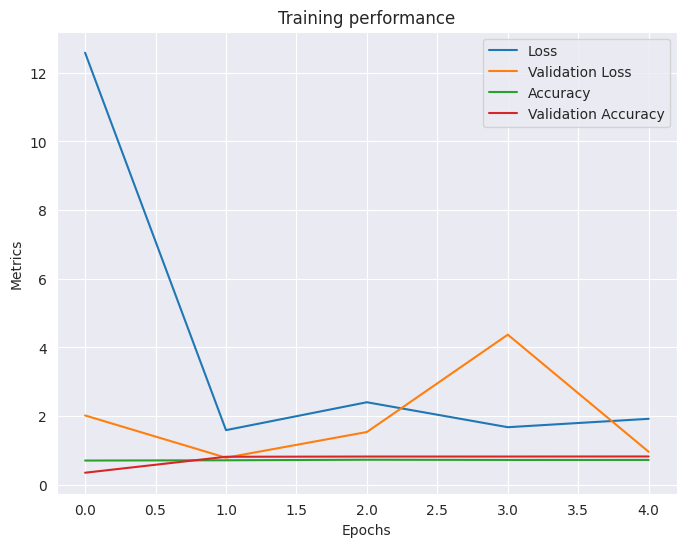

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_acl, "./axial_acl_model")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # Consider a smaller variant
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set image data format (assuming channels last)
tf.keras.backend.set_image_data_format("channels_last")

# Load EfficientNetB0 pre-trained model without the top layer
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Get the output of the EfficientNetB0 model
efficientnet_output = efficientnet_model.output

# Add a single Dense layer for classification
last_layer = GlobalAveragePooling2D()(efficientnet_output)
last_layer = Dense(1, activation='sigmoid')(last_layer)

# Create the modified model
modified_efficientnet_model = Model(inputs=efficientnet_model.input, outputs=last_layer)

# Freeze the pre-trained EfficientNetB0 layers and fine-tune the top layer
for layer in modified_efficientnet_model.layers[:-1]:
    layer.trainable = False

modified_efficientnet_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

modified_efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:

# Define a custom callback for tracking F1 score, precision, recall, and confusion matrix
class Metrics(Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x
        targ = self.val_y

        score = np.asarray(self.model.predict(x, batch_size=self.batch_size))
        predict = np.round(score)

        _f1 = f1_score(targ, predict, average='micro')
        cm = confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1))

        self.f1s.append(_f1)
        self.confusion.append(cm)

        print(f"\nAt epoch {epoch} F1-score: {_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        return

# Instantiate the custom metrics callback
metrics = Metrics(val_x=training_set_axial, val_y=training_label_acl)

# Add early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Define the fit_model function for training and evaluation
def fit_model(training_set, training_labels, model_file_name):
    history = modified_efficientnet_model.fit(
        x=training_set,
        y=training_labels,
        batch_size=32,
        epochs=30,
        validation_split=0.10,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_loss', mode='min'),
            ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')
        ]
    )
    plot_history(history)
    best_model = load_model(model_file_name + '.keras')


    return best_model

# Plot training performance
def plot_history(history):
    plt.figure(figsize=(8, 6))
    sns.set_style('darkgrid')
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    if hasattr(metrics, 'f1s'):
        plt.plot(metrics.f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, color='white')
    plt.show()


Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 376ms/step - accuracy: 0.5700 - loss: 0.6724 - val_accuracy: 0.8230 - val_loss: 0.4793
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 353ms/step - accuracy: 0.8206 - loss: 0.4718 - val_accuracy: 0.8230 - val_loss: 0.4565
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.8199 - loss: 0.4585 - val_accuracy: 0.8230 - val_loss: 0.4426
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.8212 - loss: 0.4481 - val_accuracy: 0.8230 - val_loss: 0.4336
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 357ms/step - accuracy: 0.8178 - loss: 0.4383 - val_accuracy: 0.8252 - val_loss: 0.4270
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 358ms/step - accuracy: 0.8211 - loss: 0.4348 - val_accuracy: 0.8274 - val_loss: 0.4213
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 355ms/step - accuracy: 0.8122 - loss: 0.4336 - val_accuracy: 0.8274 - val_loss: 0.4170
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.8215 - loss: 0

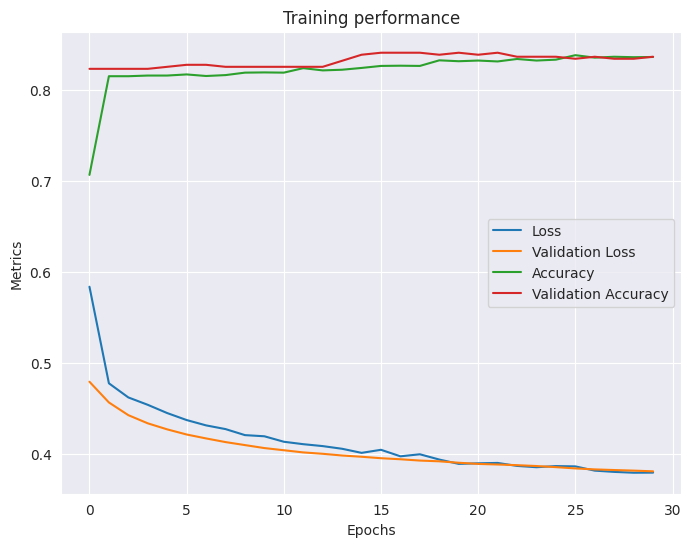

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_acl, "./axial_acl_model")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # Consider a smaller variant
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set image data format (assuming channels last)
tf.keras.backend.set_image_data_format("channels_last")

# Load EfficientNetB0 pre-trained model without the top layer
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Get the output of the EfficientNetB0 model
efficientnet_output = efficientnet_model.output

# Add a single Dense layer for classification
last_layer = GlobalAveragePooling2D()(efficientnet_output)
last_layer = Dense(1, activation='sigmoid')(last_layer)

# Create the modified model
modified_efficientnet_model = Model(inputs=efficientnet_model.input, outputs=last_layer)

# Freeze the pre-trained EfficientNetB0 layers and fine-tune the top layer
#for layer in modified_efficientnet_model.layers[:-1]:
   # layer.trainable = False

modified_efficientnet_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

modified_efficientnet_model.summary()

# Define a custom callback for tracking F1 score, precision, recall, and confusion matrix
class Metrics(Callback):
    def __init__(self, val_x, val_y, batch_size=20):
        super().__init__()
        self.val_x = val_x
        self.val_y = val_y
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs=None):
        x = self.val_x
        targ = self.val_y

        score = np.asarray(self.model.predict(x, batch_size=self.batch_size))
        predict = np.round(score)

        _f1 = f1_score(targ, predict, average='micro')
        cm = confusion_matrix(targ.argmax(axis=1), predict.argmax(axis=1))

        self.f1s.append(_f1)
        self.confusion.append(cm)

        print(f"\nAt epoch {epoch} F1-score: {_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        return

# Instantiate the custom metrics callback
metrics = Metrics(val_x=training_set_axial, val_y=training_label_acl)

# Add early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Define the fit_model function for training and evaluation
def fit_model(training_set, training_labels, model_file_name):
    history = modified_efficientnet_model.fit(
        x=training_set,
        y=training_labels,
        batch_size=32,
        epochs=30,
        validation_split=0.10,
        callbacks=[
            EarlyStopping(patience=3, monitor='val_loss', mode='min'),
            ModelCheckpoint(model_file_name + '.keras', monitor='val_accuracy', save_best_only=True, mode='max', save_freq='epoch')
        ]
    )
    plot_history(history)
    best_model = load_model(model_file_name + '.keras')


    return best_model

# Plot training performance
def plot_history(history):
    plt.figure(figsize=(8, 6))
    sns.set_style('darkgrid')
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    if hasattr(metrics, 'f1s'):
        plt.plot(metrics.f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, color='white')
    plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

NameError: name 'Callback' is not defined

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7134 - loss: 2.3875 - val_accuracy: 0.8230 - val_loss: 1.7972
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7179 - loss: 2.0898 - val_accuracy: 0.8230 - val_loss: 2.1733
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7441 - loss: 1.5368 - val_accuracy: 0.8230 - val_loss: 1.2181
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.6927 - loss: 3.5913 - val_accuracy: 0.8230 - val_loss: 1.4199
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7054 - loss: 2.7572 - val_accuracy: 0.1770 - val_loss: 2.8234
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.6890 - loss: 1.2193 - val_accuracy: 0.8230 - val_loss: 0.8710
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7459 - loss: 0.8482 - val_accuracy: 0.8230 - val_loss: 1.3401
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.7691 - loss: 0.7759 - val_accu

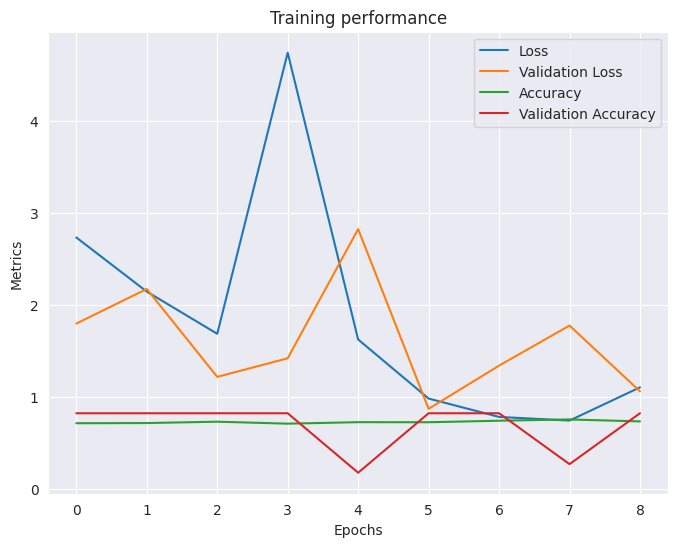

In [ ]:
axial_abnormal_model = fit_model(training_set_axial, training_label_acl, "./axial_acl_model")

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical

# Import libraries for saliency map generation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
# Normalize the image
mri_axial_norm = mri_axial[0, :, :] /255.0

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def generate_saliency_map(model, image):
    # Wrap the model to compute gradients
    grad_model = tf.keras.Model(
        inputs=model.inputs, outputs=model.output[..., 0]
    )

    # Define a loss function to maximize the model output
    def loss(inputs):
        return -tf.reduce_mean(grad_model(inputs))

    # Create a gradient ascent optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # Convert the image to a tensor with batch dimension
    image_tensor = np.expand_dims(image, axis=0)
    # Convert the image_tensor to a TensorFlow Tensor
    image_tensor = tf.convert_to_tensor(image_tensor, dtype=tf.float32)

    # Make image_tensor a trainable variable
    image_tensor = tf.Variable(image_tensor)

    # Iteratively update the image to maximize the model output
    for _ in range(50):
        with tf.GradientTape() as tape:
            tape.watch(image_tensor)
            predictions = grad_model(image_tensor)
        grads = tape.gradient(predictions, image_tensor)
        optimizer.apply_gradients([(grads, image_tensor)])

    # Normalize the saliency map and clip values between 0 and 1
    saliency_map = tf.squeeze(image_tensor).numpy()
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    saliency_map = np.clip(saliency_map, 0, 1)

    return saliency_map

# Load the pre-trained EfficientNetB0 model without the top layer
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[0, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)


# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[0, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'mri_axial' is not defined

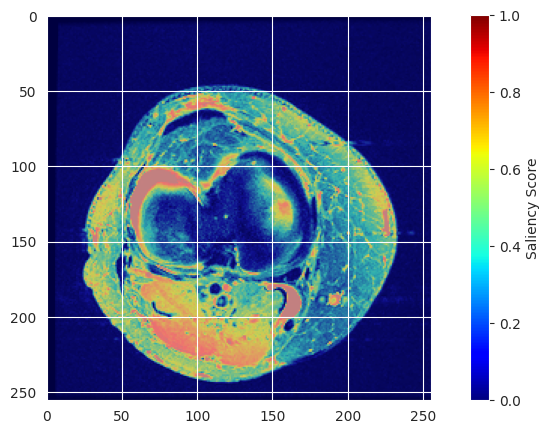

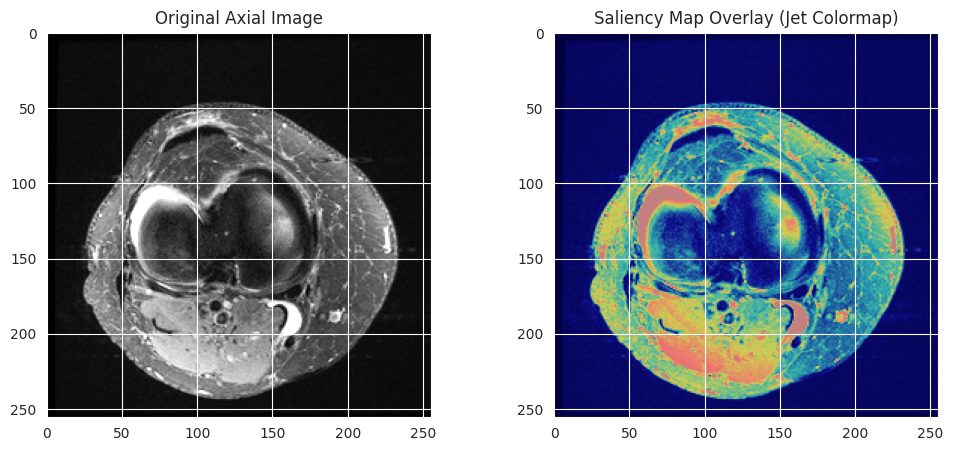

In [ ]:
mri_axial_norm = mri_axial[30, :, :] /255.0
# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[30, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)

# Overlay saliency map on the original axial image
# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[30, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()

In [ ]:
mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/0002.npy')
mri_axial_norm = mri_axial[15, :, :] / 255.0

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[15, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)

# Overlay saliency map on the original axial image
# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[15, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()

NameError: name 'np' is not defined

In [ ]:
mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/0002.npy')
mri_axial_norm = mri_axial[30, :, :] / 255.0

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[30, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)

# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[30, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()